In [62]:
import torch

In [63]:
a = torch.tensor(
    [2., 3.], 
    requires_grad=True
    )
b = torch.tensor(
    [6., 4.], 
    requires_grad=True
    )
Q = 3*a**3 -b**2
print(Q, a.grad, b.grad)

external_grad = torch.tensor([1,1])
Q.backward(gradient = external_grad)
print(Q, a.grad, b.grad)

tensor([-12.,  65.], grad_fn=<SubBackward0>) None None
tensor([-12.,  65.], grad_fn=<SubBackward0>) tensor([36., 81.]) tensor([-12.,  -8.])


In [64]:
## define a neural network
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input channel, 6 output channels, 5*5 square convolution
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # if the size is a square you can specify with single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except batch dimension (??)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)



Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [65]:
params = list(net.parameters())
print(len(params))
print(params[0].size())

10
torch.Size([6, 1, 5, 5])


In [66]:
input = torch.randn(1,1,32,32)
out = net(input)
print(input)
print(out)

tensor([[[[ 1.2339,  1.3750, -0.0568,  ..., -0.8444,  0.1542,  1.7339],
          [ 1.4079, -0.2006, -1.2414,  ...,  0.0411, -1.3698, -1.0529],
          [-0.2137,  0.1990, -2.0539,  ...,  0.1094, -2.6435,  1.6709],
          ...,
          [-1.2033,  0.7908,  0.0034,  ..., -0.4611,  1.2922, -0.4784],
          [-0.7608,  0.0486,  1.3523,  ..., -0.8648, -0.7194, -0.1200],
          [ 0.6577, -0.3468,  0.4076,  ..., -1.1706, -0.6507,  0.7512]]]])
tensor([[ 0.1589,  0.0530, -0.0522, -0.0467, -0.0547, -0.0386,  0.0507,  0.0028,
         -0.0263,  0.0454]], grad_fn=<AddmmBackward0>)


In [67]:
# what does this do? revert the above?
net.zero_grad()
out.backward(torch.randn(1, 10))

In [68]:
# loss function
output = net(input)
target = torch.randn(10) # set a dummy target
target = target.view(1, -1) # same as np.reshape()
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.0258, grad_fn=<MseLossBackward0>)


In [69]:
# backprop
# zero the gradients so that gradients aren't accumulated to existing gradients (??)

net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)


conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0050, -0.0069, -0.0002,  0.0058,  0.0076,  0.0299])


In [70]:
# update the weights
# using optim
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr = 0.01)

# put this in a training loop
optimizer.zero_grad()
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()

# Training a Classifier
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 

In [71]:
import torchvision
import torchvision.transforms as transforms

In [72]:
## resolves issue with ssl certs in PyTorch
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
##
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
                    (0.5, 0.5, 0.5),
                    (0.5, 0.5, 0.5)
                        )
    ]
)

batch_size = 4

trainset = torchvision.datasets.CIFAR10(
    root = './data',
    train = True,
    download = True,
    transform = transform
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True, 
    num_workers = 2
)

testset = torchvision.datasets.CIFAR10(
    root = './data',
    train = False,
    download = True,
    transform = transform
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size = batch_size,
    shuffle = False,
    num_workers = 2
)

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




Files already downloaded and verified
Files already downloaded and verified


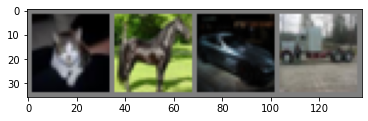

cat   horse car   truck


In [73]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels (for each batch i.e 4)
print(
    ' '.join(
        f'{classes[labels[j]]:5s}' for j in range(batch_size)
    )
)

In [150]:
# create a convolutional NN

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 input chanels (r, g, b), 6 output channels, 5*5 conv
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ResNet(nn.Module):
    """
    Attempt at trying a resnet model
    Resnet is understood to have a 'skip connection' 
    see https://www.geeksforgeeks.org/residual-networks-resnet-deep-learning/
    """
    def __init__(self):
        super().__init__()
        # 3 input chanels (r,g, b), 6 output channels, 5*5 conv
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.fc4 = nn.Linear(10, 10) # for skip connection

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # skip connection
        x = F.relu(self.fc4(x))
        x = self.fc4(x) + x # add to residual
        return x
net = ConvNet()

In [151]:
# cross-entropy loss, use SGD with momentum
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [163]:
# create training function to play with hyperparams
def Train(net, epochs, trainloader, criterion, optimizer):
    # train the network
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients (still not sure what this is really?)
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print stats
            running_loss += loss.item()
            if i % 2000 == 1999: # print every 2000 minibatches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0 # why reset this? - its an average loss for last 2000 mini batches


    print('Finished Training')


def Eval(net, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')



In [165]:
# networks to test
net1 = ConvNet()
net2 = ConvNet()
net3 = ConvNet()
net4 = ConvNet()

# one criterion for all
criterion = nn.CrossEntropyLoss()

# optimizers
optimizer1 = optim.SGD(net1.parameters(), lr = 0.0005, momentum = 0.9)
optimizer2 = optim.SGD(net2.parameters(), lr = 0.001, momentum = 0.9)
optimizer3 = optim.SGD(net3.parameters(), lr = 0.002, momentum = 0.9)
optimizer4 = optim.SGD(net4.parameters(), lr = 0.004, momentum = 0.9)

In [167]:
Train(net1, 1, trainloader, criterion, optimizer1)
# Train(net2, 5, trainloader, criterion, optimizer2)
# Train(net3, 5, trainloader, criterion, optimizer3)
# Train(net4, 5, trainloader, criterion, optimizer4)

[1,  2000] loss: 2.304
[1,  4000] loss: 2.303
[1,  6000] loss: 2.303
[1,  8000] loss: 2.303
[1, 10000] loss: 2.303
[1, 12000] loss: 2.304
Finished Training


In [164]:
Eval(net1, testloader)
# Eval(net2, testloader)
# Eval(net3, testloader)
# Eval(net4, testloader)


Accuracy of the network on the 10000 test images: 63 %


In [152]:
# train the network
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients (still not sure what this is really?)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print stats
        running_loss += loss.item()
        if i % 2000 == 1999: # print every 2000 minibatches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0 # why reset this? - its an average loss for last 2000 mini batches


print('Finished Training')


[1,  2000] loss: 2.197
[1,  4000] loss: 1.826
[1,  6000] loss: 1.626
[1,  8000] loss: 1.526
[1, 10000] loss: 1.477
[1, 12000] loss: 1.408
[2,  2000] loss: 1.333
[2,  4000] loss: 1.328
[2,  6000] loss: 1.277
[2,  8000] loss: 1.261
[2, 10000] loss: 1.226
[2, 12000] loss: 1.228
Finished Training


In [77]:
# save the model

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

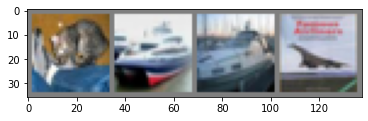

Ground Truth:  cat   ship  ship  plane


In [153]:
# review the model on the test data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Ground Truth: ',
' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))


In [154]:
# apply the net
outputs = net(images)

In [155]:
outputs == outputs.data
# what is outputs.data???

tensor([[True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True]])

In [156]:


_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


In [157]:
# evaluate network against the whole dataset
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [158]:
# check against
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect correct pred for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 50.2 %
Accuracy for class: car   is 78.9 %
Accuracy for class: bird  is 44.0 %
Accuracy for class: cat   is 27.8 %
Accuracy for class: deer  is 51.2 %
Accuracy for class: dog   is 41.6 %
Accuracy for class: frog  is 86.5 %
Accuracy for class: horse is 57.6 %
Accuracy for class: ship  is 74.2 %
Accuracy for class: truck is 56.2 %


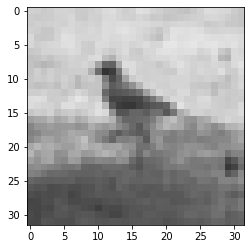

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


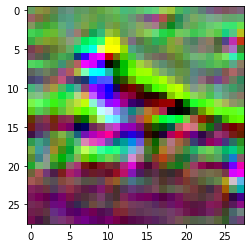

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


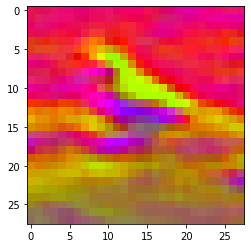

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


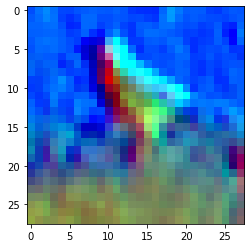

In [160]:
# how can I get the convolution for a single image?
i = 0
imshow(inputs[i])
imshow(net.conv1(inputs[i]).detach()[:3,:,:])
imshow(net.conv1(inputs[i]).detach()[3:6,:,:])
imshow(net.conv1(inputs[i]).detach()[6:,:,:])

In [127]:
texts = [50,36, 43,49, 38]
sum(texts )

216